# Packages required

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import time
import os
import glob
import cv2
import ujson as json
#import json
from collections import OrderedDict
from collections import Counter

import seaborn as sns
import math
import datetime
from collections import defaultdict


In [2]:
## Sklearn stuff
#from sklearn.model_selection import StratifiedKFold
from math import sqrt
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_curve, auc #roc_auc_score as AUC

In [3]:
## Keras stuffs
from keras import __version__ as keras_version
print('Keras version: {}'.format(keras_version))
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD,Adam
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.preprocessing import image
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping

Using TensorFlow backend.


Keras version: 1.2.2


In [4]:
## our functions
from ipinyouReader import * #name overlap
import ipinyouWriter
import BidModels
from Evaluator import * #name overlap

# Hyperparams to tune

In [5]:
### Data
TRAIN_FILE_PATH="./data.pruned/train_cleaned_prune.csv" #"../dataset/train.csv"
VALIDATION_FILE_PATH="./data.pruned/validation_cleaned_prune.csv" #"../dataset/validation.csv"
MODEL_CHECKPOINT_FILE_PATH="Keras-LR_mu_2_2.hdf5"

#Stratification
NUM_K_FOLDS=1
SHUFFLE_INPUT=True
RANDOM_SEED=None #or int

### Weights
CLASS_WEIGHTS_MU=2.2 #0.8 #0.15

### Training
BATCH_SIZE = 128
TOTAL_EPOCHS = 30
DROPOUT_PROB=0.2
LEARNING_RATE=0.003

# Load data files

In [6]:
# # Read in train.csv to train the model
#trainReader = ipinyouReader.ipinyouReader(TRAIN_FILE_PATH)
trainReader = ipinyouReader.ipinyouReader(TRAIN_FILE_PATH)
#trainData = trainReader.getTrainData()

# Read in Validation.csv for developmental testing
#devReader = ipinyouReader.ipinyouReader(VALIDATION_FILE_PATH)
devReader = ipinyouReader.ipinyouReader(VALIDATION_FILE_PATH)
#devData = devReader.getTestData()


In [7]:
devData = devReader.getDataFrame()
trainData = trainReader.getDataFrame()

In [8]:
devData

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,5,12,5efc19765061bab7f833658e9da87da7,1,u_Vh2r1ATx3vB9DBE,windows_chrome,222.175.103.*,146,147,...,600,2,0,39,e87d7633d474589c2e2e3ba4eda53f6c,300,44,361e128affece850342293213691a043,3386,"10083,10006,14273,10052,10063,10110"
1,0,3,12,22d8368d8bccb7c7bc83db5e6030530b,1,u_Z0phPrCyPtdUXYk,windows_ie,58.222.155.*,80,92,...,600,2,0,5,cb7c76e7784031272e37af8e7e9b062c,300,41,bebefa5efe83beee17a3d245e7c5085b,1458,"10006,13776"
2,0,5,1,7e57cca3cd10664a9cd7645204dc1266,1,u_Vh5zZDBI3tqLFOC,mac_safari,122.194.13.*,80,85,...,90,0,1,0,fa8f0532dd5144b5fa748459e8d90b49,227,17,0f951a030abdaedd733ee8d114ce2944,3427,null
3,0,0,21,4f91e5c406096c473d45b596aaac0736,1,u_VhkYPpq5LQ5cBQc,windows_ie,119.187.242.*,146,151,...,90,0,0,20,832b91d59d0cb5731431653204a76c0e,300,87,bebefa5efe83beee17a3d245e7c5085b,1458,"10076,10063,10006,10059,10111"
4,0,0,21,65ce61fc67e2d1bca7159ba6e34888f0,1,u_DAKAS8FTs1J,windows_chrome,27.46.122.*,216,219,...,250,Na,Na,50,10722,294,260,null,2821,"10057,10059,10684,14273,10077,10006,10024,1011..."
5,0,0,22,91b1ce825f69a6860bffe86d4578c4f9,1,u_VhkR15F-Oep_lWl,windows_chrome,114.241.136.*,1,1,...,90,1,1,0,b90c12ed2bd7950c6027bf9c6937c48a,300,4,361e128affece850342293213691a043,3386,"10063,10059,10006,10111"
6,0,6,9,f79a3d58ea9048990b000ee739ba9e21,1,u_Vhk7C3TkPUjhgQB,windows_ie,110.205.123.*,201,213,...,600,0,0,162,fe222c13e927077ad3ea087a92c0935c,238,182,d29e59bf0f7f8243858b8183f14d4412,3358,null
7,0,0,22,3164a0511505b782f3b90b3f62092acd,1,u_DAHCBd8jugw,windows_chrome,58.242.164.*,106,109,...,90,FirstView,Na,0,10717,294,9,null,2821,null
8,1,6,22,f7ff02cf66d13910fc3edc8574ec8710,1,u_Vhk71eTnDNk83-j,mac_safari,125.107.46.*,94,100,...,250,1,5,0,44966cc8da1ed40c95d59e863c8c75f0,300,115,361e128affece850342293213691a043,3386,null
9,0,0,17,e8a73716d771891e890505110d8b6372,1,u_DALHJ05oti3,windows_chrome,121.33.234.*,216,217,...,250,FirstView,Na,5,7321,277,205,null,2259,null


In [9]:
trainData

,click,weekday,hour,bidid,logtype,userid,useragent,IP,region,city,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,3,12,bad96e5abbb3edaa07e799147984d052,1,u_VhkxVxf9OTmUQfB,windows_ie,223.241.13.*,106,108,...,90,0,0,50,c46090c887c257b61ab1fa11baee91d8,241,55,0f951a030abdaedd733ee8d114ce2944,3427,10063
1,1,6,7,a373965aa5613d6f8faecb4ebb48d50b,1,u_VhdTOe5PO8zW3sn,windows_chrome,27.152.193.*,124,129,...,90,1,0,5,b90c12ed2bd7950c6027bf9c6937c48a,300,96,361e128affece850342293213691a043,3386,"13776,13800,10024"
2,0,5,0,8fa00639ef7b95b263868e7a93ce81a7,1,u_D1ALUC1ocq6,windows_firefox,113.116.61.*,216,219,...,250,Na,Na,50,7323,294,50,null,2259,"10048,14273,10083,13042,11423,10110,13776,1340..."
3,1,0,7,1711992a95af8ff837ec8e4aadc5f709,1,u_VhkEO3LyPUFLXZa,windows_ie,112.92.74.*,216,220,...,250,0,0,50,e1af08818a6cd6bbba118bb54a651961,254,150,a5d0bde104fea52ea466c77b37948424,3476,"13403,10076,10006,10063,10075,10110"
4,0,1,15,c73e82f75453032c1584cfdd34ec5317,1,u_VhkxPa52PQTVGQk,windows_chrome,218.206.193.*,164,165,...,250,1,0,5,2abc9eaf57d17a96195af3f63c45dc72,300,213,bebefa5efe83beee17a3d245e7c5085b,1458,null
5,0,3,2,83c91f70abc242e7e0a9a5a26a80b26a,1,u_Vhky1AayOtm2JCn,windows_ie,125.83.231.*,275,275,...,600,2,0,5,cb7c76e7784031272e37af8e7e9b062c,300,40,bebefa5efe83beee17a3d245e7c5085b,1458,13776
6,0,0,20,7cb7f6e838bdd770cb66c104f2ed2641,1,u_D8CLGG5pyb5,windows_ie,110.242.73.*,3,9,...,250,SecondView,Na,0,10722,294,238,null,2821,"16751,11278,14273,10083,13776,10110,10138,1340..."
7,0,2,12,d2b0a79b90930cb9314a6f86d397467d,1,u_VhkyC3sELHmZFQL,windows_ie,182.85.146.*,134,135,...,90,1,0,5,b90c12ed2bd7950c6027bf9c6937c48a,300,60,361e128affece850342293213691a043,3386,"10006,13800,10024"
8,0,2,20,ce9a6a293e3c592ed3fecde999f7c8f6,1,u_VhkyLRlIDtcW3Bl,windows_chrome,221.1.97.*,146,153,...,250,1,0,5,449a22cd91d9042eda3d3a1b89a22ea8,238,148,0f951a030abdaedd733ee8d114ce2944,3427,null
9,0,5,9,a8c054432544541c225b240361b1831e,1,u_DA6MUW2yt5X,windows_chrome,123.245.99.*,40,41,...,100,Na,Na,0,12621,294,109,null,2261,"10083,10006,11423,10110,10131,13403,10063"


# Preprocess data

In [10]:
trainOneHotData,trainY = trainReader.getOneHotData()
devOneHotData,devY = devReader.getOneHotData(train_cols=trainOneHotData.columns.get_values().tolist())

X_train = trainOneHotData.as_matrix()
Y_train = trainY.as_matrix()
X_val = devOneHotData.as_matrix()
Y_val = devY.as_matrix()

In [11]:
print(len(trainOneHotData.columns))
print(len(devOneHotData.columns))

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

2465
2465
(9930, 2465)
(9930, 3)
(1100, 2465)
(1100, 3)


In [12]:
# for i in trainOneHotData.dtypes:
#     print(i)

# Class Weights

In [13]:
#devY['click'].value_counts()[0]
trainY['click'].unique()

array([0, 1])

In [14]:
# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(trainY,mu=CLASS_WEIGHTS_MU):
    total = len(trainY['click'])
    keys = trainY['click'].unique()
    class_weight = dict()
    #print(total)
    
    for key in keys:
        #print(trainY['click'].value_counts()[key])
        score = math.log(mu*total/float(trainY['click'].value_counts()[key]))
        #print(score)
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

train_class_weight=create_class_weight(trainY)
print(train_class_weight)

{0: 1.0116009116784799, 1: 2.3978952727983707}


# Create the model

In [15]:
output_dim = nb_classes = 2
input_dim = len(trainOneHotData.columns)

In [16]:
Y_click_train = to_categorical(Y_train[:,0], nb_classes)
Y_click_val = to_categorical(Y_val[:,0], nb_classes)

In [17]:
#Y_click_train
#Y_train[0,:]

In [18]:
# define model
model = Sequential()
model.add(Dense(output_dim, input_dim=input_dim, activation='softmax'))


In [19]:
optimizer = SGD(lr = LEARNING_RATE, momentum = 0.9, decay = 0.0, nesterov = True)
#optimizer=Adam(lr=LEARNING_RATE)

# compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 2)             4932        dense_input_1[0][0]              
Total params: 4,932
Trainable params: 4,932
Non-trainable params: 0
____________________________________________________________________________________________________


In [21]:
model.get_config()

[{'class_name': 'Dense',
  'config': {'W_constraint': None,
   'W_regularizer': None,
   'activation': 'softmax',
   'activity_regularizer': None,
   'b_constraint': None,
   'b_regularizer': None,
   'batch_input_shape': (None, 2465),
   'bias': True,
   'init': 'glorot_uniform',
   'input_dim': 2465,
   'input_dtype': 'float32',
   'name': 'dense_1',
   'output_dim': 2,
   'trainable': True}}]

In [22]:
#'weekday', 'hour', 'useragent split _', 'IP split . first?', 'region', 'city', 
#'adexchange', 'domain', 
#'slotwidth', 'slotheight', 'slotvisibility', 'slotformat',
#'slotprice *** should always be smaller than payprice? (but not true), or bidprice -- true', 
#'creative', 'keypage','advertiser', 
#'usertag split ',' into each tag


# y values:
# 'click','bidprice (note relation to slotprice reserve price too)', 'payprice',

# Train the model

In [23]:
#saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath=MODEL_CHECKPOINT_FILE_PATH, verbose=1, save_best_only=True)

# early stopping one class only
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=0)
# early stopping ht+class
#earlystopper = EarlyStopping(monitor='val_class_loss', patience=2, verbose=0)

# # For both
# history=model.fit(train_data, [train_downsampled_ht, to_categorical(train_target)], \
#           batch_size=BATCH_SIZE, nb_epoch=TOTAL_EPOCHS, 
#           validation_data=(validation_data, [validation_downsampled_ht, to_categorical(validation_target)]),
#           class_weight=train_class_weight,
#           callbacks=[checkpointer,earlystopper]
#          ) #TODO add callbacks, shuffle?

## For click pred only
history=model.fit(X_train, [Y_click_train], \
          batch_size=BATCH_SIZE, nb_epoch=TOTAL_EPOCHS, 
          validation_data=(X_val, [Y_click_val]),
          class_weight=train_class_weight,
          callbacks=[checkpointer,earlystopper]
         ) #TODO add callbacks, shuffle?

Train on 9930 samples, validate on 1100 samples
Epoch 1/30
9930/9930 [==============================] - 1s - loss: 0.8130 - acc: 0.7882 - val_loss: 0.5186 - val_acc: 0.8264
Epoch 2/30
9930/9930 [==============================] - 0s - loss: 0.7512 - acc: 0.8265 - val_loss: 0.4992 - val_acc: 0.8345
Epoch 3/30
9930/9930 [==============================] - 0s - loss: 0.7221 - acc: 0.8352 - val_loss: 0.4731 - val_acc: 0.8409
Epoch 4/30
9930/9930 [==============================] - 0s - loss: 0.7031 - acc: 0.8395 - val_loss: 0.4774 - val_acc: 0.8464
Epoch 5/30
9930/9930 [==============================] - 0s - loss: 0.6882 - acc: 0.8463 - val_loss: 0.4576 - val_acc: 0.8473
Epoch 6/30
9930/9930 [==============================] - 0s - loss: 0.6763 - acc: 0.8456 - val_loss: 0.4474 - val_acc: 0.8509
Epoch 7/30
9930/9930 [==============================] - 0s - loss: 0.6665 - acc: 0.8479 - val_loss: 0.4453 - val_acc: 0.8582
Epoch 8/30
9930/9930 [==============================] - 0s - loss: 0.6581 - a

In [24]:
# history = model.fit(X_train, Y_click_train,
#                     batch_size=BATCH_SIZE, nb_epoch=TOTAL_EPOCHS,
#                     verbose=1, validation_data=(X_val, Y_click_val))
# score = model.evaluate(X_val, Y_click_val, verbose=0)

# print('Test score:', score[0])
# print('Test accuracy:', score[1])


# Load best trained model

In [25]:
def load_trained_model(weights_path):
    #model = create_model()
    model.load_weights(weights_path)

In [26]:
load_trained_model(MODEL_CHECKPOINT_FILE_PATH)

# Make click predictions using model

In [27]:
prob_click_train = model.predict(X_train)
prob_click_val = model.predict(X_val)

In [28]:
#prob_click_val[0:22,1]
#pred_click_val[0:22,1]
#Y_click_val[0:22,1]

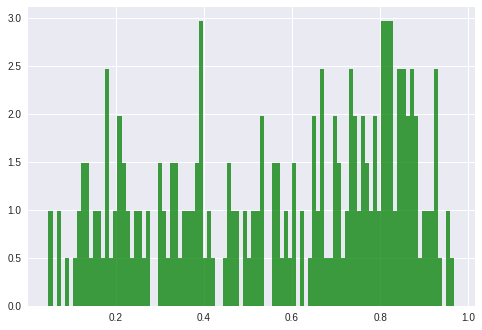

In [29]:
# click=1 prediction as click = =1 probabilities
click1=prob_click_val[Y_click_val[:,1].astype(bool),1]
# the histogram of the data
n, bins, patches = plt.hist(click1, 100, normed=True, facecolor='g', alpha=0.75)
# for item in patches:
#     item.set_height(item.get_height()/sum(n))

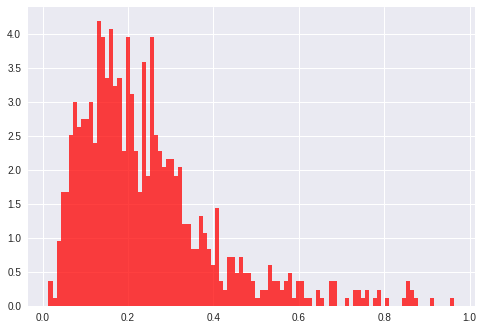

In [30]:
# click=0 prediction as click=1 probabilities
click0=prob_click_val[Y_click_val[:,0].astype(bool),1]
# the histogram of the data
n, bins, patches = plt.hist(click0, 100, normed=True, facecolor='r', alpha=0.75)
# for item in patches:
#     item.set_height(item.get_height()/sum(n))

In [31]:
# just pick whichever prob is higher as prediction
pred_click_train=(prob_click_train == prob_click_train.max(axis=1, keepdims=True)).astype(int)
pred_click_val=(prob_click_val == prob_click_val.max(axis=1, keepdims=True)).astype(int)
pred_1_click_train=pred_click_train[:,1]
pred_1_click_val=pred_click_val[:,1]

# # Pick pred_threshold for click=1 as click=1
# pred_threshold=0.3
# pred_1_click_train=np.greater_equal(prob_click_train[:,1],pred_threshold).astype(int)
# pred_1_click_val=np.greater_equal(prob_click_val[:,1],pred_threshold).astype(int)

# Gold 
Y_1_click_train =Y_click_train[:,1]
Y_1_click_val =Y_click_val[:,1]



In [32]:
click_eval=ClickEvaluator()

In [33]:
#Train
click_precision,click_recall,click_f1score=\
    click_eval.printClickPredictionScore(y_Pred=pred_1_click_train,y_Gold=Y_1_click_train)

Number of 1 in pred:  1812
Number of 0 in pred:  8118
Number of 1 in gold:  1986
Number of 0 in gold:  7944
Click=0 	Precision\pCTR: 0.900 	Recall: 0.920 	F1: 0.910
Click=1 	Precision\pCTR: 0.648 	Recall: 0.591 	F1: 0.618


In [34]:
#Validation
click_precision,click_recall,click_f1score=\
    click_eval.printClickPredictionScore(y_Pred=pred_1_click_val,y_Gold=Y_1_click_val)

Number of 1 in pred:  197
Number of 0 in pred:  903
Number of 1 in gold:  220
Number of 0 in gold:  880
Click=0 	Precision\pCTR: 0.904 	Recall: 0.927 	F1: 0.915
Click=1 	Precision\pCTR: 0.675 	Recall: 0.605 	F1: 0.638


In [35]:
# Plot data https://vkolachalama.blogspot.co.uk/2016/05/keras-implementation-of-mlp-neural.html
def roc_results_plot(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    
    plt.show()
    print('AUC: %f' % roc_auc)

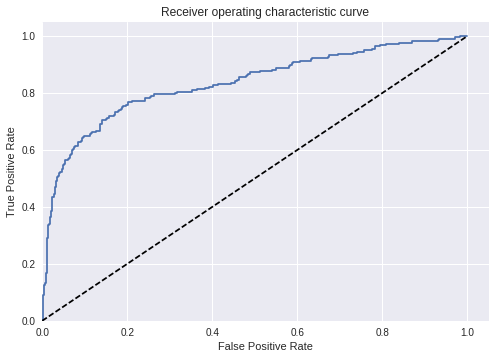

AUC: 0.834406


In [36]:
roc_results_plot(Y_click_val[:,1],prob_click_val[:,1])